# Lab Assignment 4

## Andrew Marquardt

Functions, Libraries, etc.

In [101]:
# libraries
%matplotlib inline
from matplotlib import pyplot as plt
import numpy as np
from tclab import TCLab, clock, Historian, Plotter
import pandas as pd
from scipy.optimize import least_squares

In [102]:
# initial setup
# heater power
P1 = 255
P2 = 50
# sample time
t_samp = 5

This is the bumpless controller generator script.

In [103]:
def PI_bumpless(Kp, Ki, MV_bar=0, MV_min=0, MV_max=100):
    MV = MV_bar
    PV_prev = None
    while True:
        t_step, SP, PV, MV = yield MV 
        e = PV - SP
        if PV_prev is not None:
            MV += -Kp*(PV - PV_prev) - t_step*Ki*e 
            MV = max(MV_min, min(MV_max, MV))
        PV_prev = PV

Question 1

The following code executes a simple heat-up for 900 seconds.

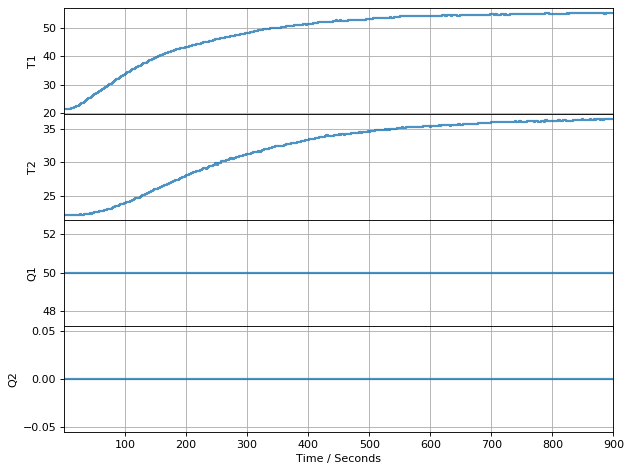

TCLab disconnected successfully.


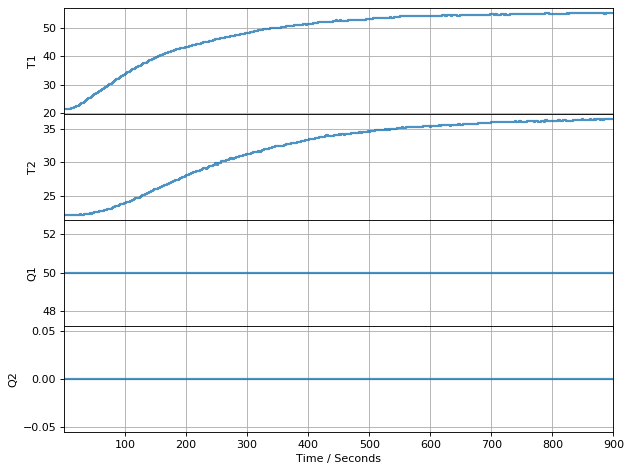

In [104]:
# Step test for tuning rules
with TCLab() as tcl:
    h = Historian(tcl.sources)
    p = Plotter(h,900)
    tcl.P1 = P1
    tcl.P2 = P2
    for t in clock(900):
        tcl.U1 = 50
        tcl.U2 = 0
        p.update(t)
h.to_csv('step_test.csv')

The following cell provides all the code necessary to fit the first order delay model and display the fit graphically.  I modified the code in order to better see the model line and switched the fit to T2 (from T1).

K = 0.296881468227441,  tau = 241.9470511705913, time delay = 71.33093484618692


Time
0.00     -3.552714e-15
2.01     -3.552714e-15
4.01     -3.552714e-15
6.01     -3.552714e-15
8.00     -3.552714e-15
10.00    -3.552714e-15
12.01    -3.552714e-15
14.00    -3.552714e-15
16.01    -3.552714e-15
18.00    -3.552714e-15
20.01    -3.552714e-15
22.01    -3.200000e-02
24.00    -3.552714e-15
26.00    -9.600000e-02
28.00    -6.400000e-02
30.01    -6.400000e-02
32.01    -9.600000e-02
34.00    -1.280000e-01
36.01    -1.280000e-01
38.01    -1.610000e-01
40.01    -1.930000e-01
42.00    -2.900000e-01
44.02    -1.930000e-01
46.01    -3.220000e-01
48.02    -3.220000e-01
50.00    -4.180000e-01
52.01    -3.860000e-01
54.00    -3.860000e-01
56.01    -4.510000e-01
58.01    -5.470000e-01
              ...     
842.00    5.102355e-02
844.01    5.610371e-02
846.01    6.111687e-02
848.01    3.408876e-02
850.00    7.099516e-02
852.01    7.591009e-02
854.01    8.076020e-02
856.01    8.557038e-02
858.01    9.034097e-02
860.01    9.507228e-02
862.01    6.776464e-02
864.00    1.043952e-01
866.01

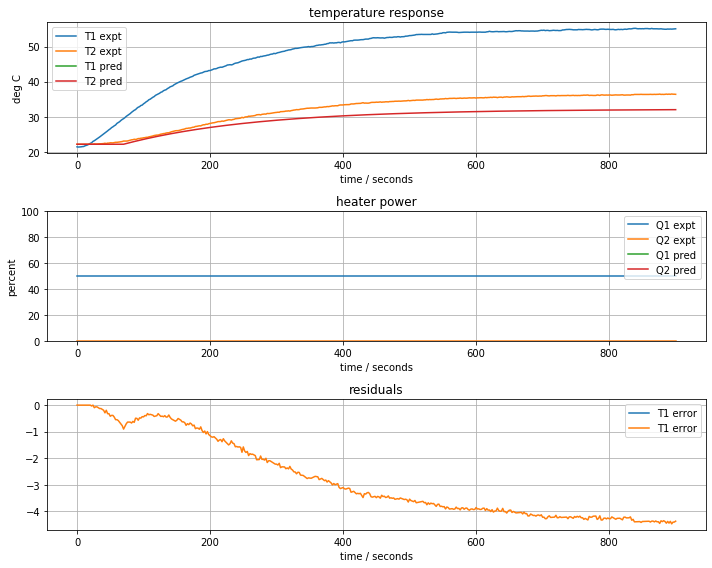

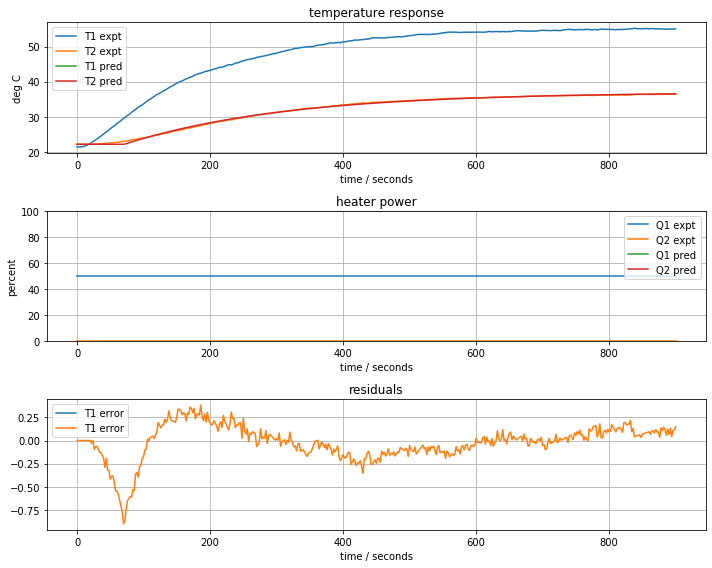

In [172]:
# create a function to compare two data sets
def plot_data(expt, pred):
    t_expt = expt.index
    
    # create a 3 x 1 grid of plot axes
    fig, ax = plt.subplots(3, 1, figsize=(10,8))
    
    # first plot axes
    ax[0].plot(t_expt, expt["T1"], label="T1 expt")
    ax[0].plot(t_expt, expt["T2"], label="T2 expt")
    ax[0].plot(t_expt, pred["T1"], label="T1 pred")
    ax[0].plot(t_expt, pred["T2"], label="T2 pred")
    ax[0].set_ylabel("deg C")
    ax[0].set_title("temperature response")

    # second plot axes
    ax[1].plot(t_expt, expt["Q1"], label="Q1 expt")
    ax[1].plot(t_expt, expt["Q2"], label="Q2 expt")
    ax[1].plot(t_expt, pred["Q1"], label="Q1 pred")
    ax[1].plot(t_expt, pred["Q2"], label="Q2 pred")
    ax[1].set_ylim([0, 100])
    ax[1].set_ylabel("percent")
    ax[1].set_title("heater power")
    
    # third plot axes
    ax[2].plot(t_expt, pred["T1"]-expt["T1"], label="T1 error")
    ax[2].plot(t_expt, pred["T2"]-expt["T2"], label="T1 error")
    ax[2].set_title("residuals")
    
    # things to do for every plot axes
    for a in ax:
        a.grid(True)
        a.set_xlabel("time / seconds")
        a.legend()
        
    plt.tight_layout()
    
    return

# import .csv file
data = pd.read_csv('step_test.csv')
data.index = data['Time']

# parameter values and units
T_amb = 22.188               # deg C
u1bar = data["Q1"].mean()
t_expt = data.index

# adjustable parameters
K = 0.2
tau = 200
t_delay = 70

def model_first_order_delay(param, plot=False):
    K, tau, t_delay = param    
    pred = pd.DataFrame(columns=["T1", "T2", "Q1", "Q2"], index=t_expt)
    pred["T2"] = [T_amb + K*u1bar*(1 - np.exp(-(t-t_delay)/tau)) if t > t_delay else T_amb for t in t_expt]
    if plot:
        plot_data(data, pred)
    return pred["T2"] - data["T2"]
    
model_first_order_delay([K, tau, t_delay], True)

results = least_squares(model_first_order_delay,  [K, tau, t_delay])
K, tau, t_delay = results.x
print(f"K = {K},  tau = {tau}, time delay = {t_delay}")
model_first_order_delay(results.x, True)



The following code is set up to run the simulation mode as a check on my model.  I do not care so much that the model behaves perfectly (the ambient temperature of the simulation mode is inaccurate and this is significant on the final results) but I would like to see the controller behaving correctly before actually subjecting the heater to this routine.

In [186]:
def sim_experiment(controller, t_final, t_step,
               SP=lambda t: 30 if t >= 0 else 0, 
               DV=lambda t: 20 if t >= 300 else 0,
               MV=lambda t: 50 if t <= 0 else None):   # <== manipulated variable. Return none for auto
    TCLab = setup(connected=False)
    with TCLab() as lab:

        # set up historian and plotter
        h = Historian(lab.sources)
        p = Plotter(h, t_final)
        lab.P1 = P1
        lab.P2 = P2
        # initialize manipulated variable
        lab.Q1(next(controller))

        # event loop
        for t in clock(t_final, t_step):
            T2 = lab.T2
            U1 = lab.Q1()
            if MV(t) is None:           
                U1 = controller.send((t_step, SP(t), T2, U1))    # automatic control
            else:
                U1 = MV(t)                                       # manual control
            lab.Q1(U1)
            lab.Q2(DV(t))
            p.update(t) 

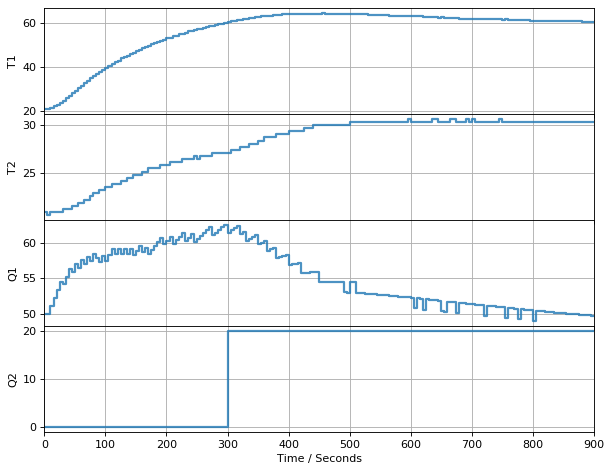

TCLab Model disconnected successfully.


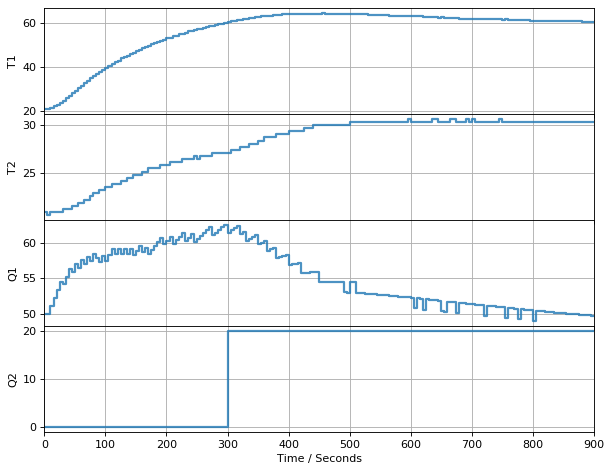

In [187]:
# 1-loop PI controller (uses windup and bumpless transfer modifications)
Kp = (0.15*t_delay+0.35*tau)/(K*t_delay)
Ki = (0.46*t_delay+0.02*tau)/(K*t_delay**2)
t_final = 900
sim_experiment(PI_bumpless(Kp,Ki),t_final,t_samp)

This is the actual run, with the heater actually operating.  The initial value of Q1 was set to 0% in order to let the controller manipulate completely. Besides examining the expected and successful controller behavior involving heater 1, it is interesting to note that the unit behaves significantly differently with a higher initial temperature and no other changes.

In [188]:
def run_experiment(controller, t_final, t_step,
               SP=lambda t: 30 if t >= 0 else 0, 
               DV=lambda t: 20 if t >= 300 else 0,
               MV=lambda t: 0 if t <= 0 else None):   # <== manipulated variable. Return none for auto
    with TCLab() as lab:

        # set up historian and plotter
        h = Historian(lab.sources)
        p = Plotter(h, t_final)
        lab.P1 = 255
        lab.P2 = 50
        # initialize manipulated variable
        lab.Q1(next(controller))

        # event loop
        for t in clock(t_final, t_step):
            T2 = lab.T2
            U1 = lab.Q1()
            if MV(t) is None:           
                U1 = controller.send((t_step, SP(t), T2, U1))    # automatic control
            else:
                U1 = MV(t)                                       # manual control
            lab.Q1(U1)
            lab.Q2(DV(t))
            p.update(t) 
        
        h.to_csv('PI_one_loop.csv')

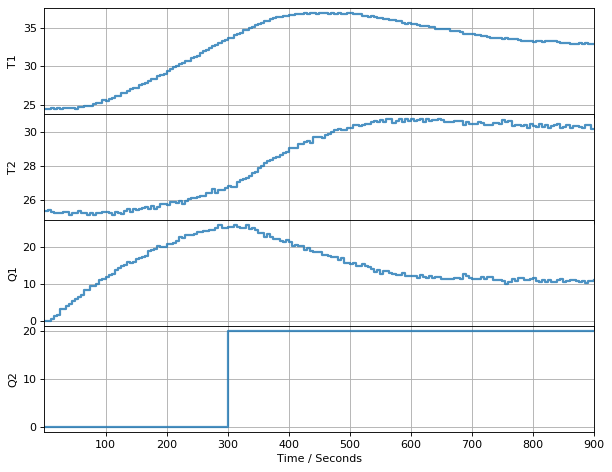

TCLab disconnected successfully.


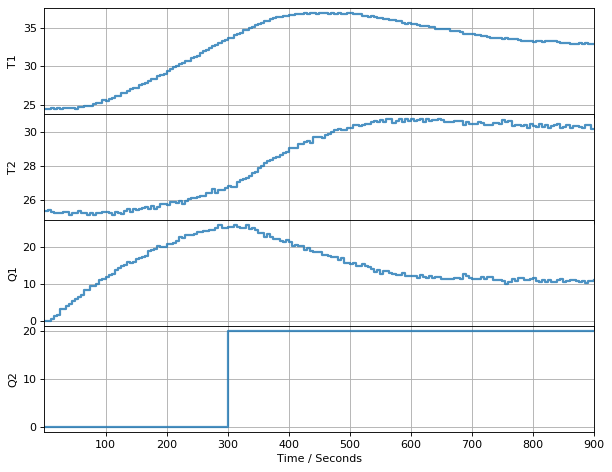

In [189]:
Kp = (0.15*t_delay+0.35*tau)/(K*t_delay)
Ki = (0.46*t_delay+0.02*tau)/(K*t_delay**2)
t_final = 900
run_experiment(PI_bumpless(Kp,Ki),t_final,t_samp)

In [191]:
with TCLab() as tcl:
    print(tcl.T1)
    print(tcl.T2)

TCLab version 0.4.9
Arduino Leonardo connected on port COM3 at 115200 baud.
TCLab Firmware 3.0.0 Arduino Leonardo/Micro.
24.443
25.056
TCLab disconnected successfully.


Question 2

In [119]:
def PI_bumpless(Kp, Ki, MV_bar=0, MV_min=0, MV_max=100):
    MV = MV_bar
    PV_prev = None
    while True:
        t_step, SP, PV, MV = yield MV 
        e = PV - SP
        if PV_prev is not None:
            MV += -Kp*(PV - PV_prev) - t_step*Ki*e 
            MV = max(MV_min, min(MV_max, MV))
        PV_prev = PV

In [168]:
# theory notes
'''
SP2 = 30
SP1 = controller(SP2,T1,T2) -> adjust SP1 based on the value of T2 relative to SP2
U1 = controller(SP1,U1,T1) -> adjust U1 based on the value of T1 relative to SP1
'''
# double controller: simulation version
def sim_double_loop(controller_outer, controller_inner, t_final, t_step,
               SP2=lambda t: 30 if t >=0 else 0,
               DV=lambda t: 20 if t >= 300 else 0,
               MVU=lambda t: 50 if t <= 0 else None,
               MVT=lambda t: 40 if t <= 0 else None,):
    TCLab = setup(connected=False, speedup=60)
    with TCLab() as lab:

        # set up historian and plotter
        h = Historian(lab.sources)
        p = Plotter(h, t_final)
        # powers are specified at top of this notebook
        lab.P1 = P1
        lab.P2 = P2
        # initialize manipulated variable
        lab.Q1(next(controller_inner))
        SP1 = next(controller_outer)

        # event loop
        for t in clock(t_final, t_step):
            T2 = lab.T2
            T1 = lab.T1
            U1 = lab.Q1()
            # outer loop occurs first; returns value for SP1
            if MVT(t) is None:           
                SP1 = controller_outer.send((t_step, SP2(t), T2, SP1))
            else:
                SP1 = MVT(t)                            # manual override for heater unit 1 temperature set point
            # inner loop occurs second, and responds to outer loop direction by specifying the heater power
            if MVU(t) is None:
                U1 = controller_inner.send((t_step, SP1, T1, U1))
            else:
                U1 = MVU(t)                             # manual override for heater unit 1 power
            lab.Q1(U1)
            lab.Q2(DV(t))
            p.update(t)
            
        h.to_csv('sim_test_double_loop.csv')

NOTE: In the directions, it states to implement anti-windup in the code written for lab 3; as far as I could tell, I did this, but my scripts utilized function notation and here I am using a generator.  So, there are no visible changes to make for this part of the question because I did not find any necessary modifications.

In [125]:
# verify inner controller functions properly
# note: K for the inner controller should be 1
def run_experiment(controller, t_final, t_step,
               SP=lambda t: 40 if t >= 0 else 0, 
               DV=lambda t: 20 if t >= 900 else 0,
               MV=lambda t: 40 if t <= 0 else None):   # <== manipulated variable. Return none for auto
    with TCLab() as lab:

        # set up historian and plotter
        h = Historian(lab.sources)
        p = Plotter(h, t_final)
        lab.P1 = P1
        lab.P2 = P2
        # initialize manipulated variable
        lab.Q1(next(controller))

        # event loop
        for t in clock(t_final, t_step):
            T1 = lab.T1
            U1 = lab.Q1()
            if MV(t) is None:           
                U1 = controller.send((t_step, SP(t), T1, U1))    # automatic control
            else:
                U1 = MV(t)                                       # manual control
            lab.Q1(U1)
            lab.Q2(DV(t))
            p.update(t) 
            
        h.to_csv('sim_test_single controller.csv')

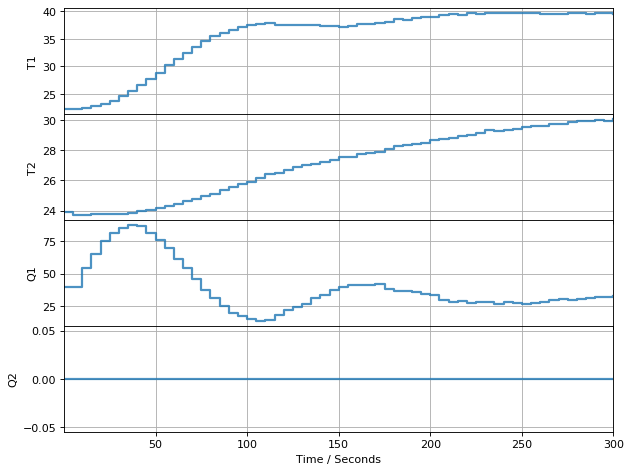

TCLab disconnected successfully.


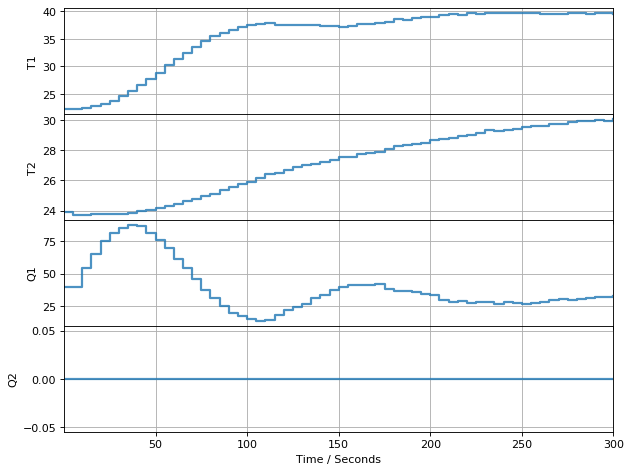

In [123]:
# run the test code above; Kp and Ki are taken directly from values I settled on in lab assignment 3
Kp = 13
Ki = 0.18
t_final = 300
run_experiment(PI_bumpless(Kp,Ki),t_final,t_samp)

K = 0.4413564865763429,  tau = 44.50210801290802, time delay = 24.153569668616598


Time
0.00     -3.552714e-15
5.01      3.200000e-02
10.00    -1.610000e-01
15.00    -5.480000e-01
20.02    -9.350000e-01
25.01    -1.187766e+00
30.00    -2.064442e-01
35.01     3.964466e-01
40.01     7.629714e-01
45.01     1.041577e+00
50.01     9.584088e-01
55.01     6.898953e-01
60.01     4.739322e-01
65.00     1.275042e-01
70.01    -2.374666e-01
75.02    -5.851660e-01
80.00    -9.076164e-01
85.02    -9.654921e-01
90.01    -1.145699e+00
95.00    -1.118101e+00
100.01   -1.101077e+00
105.02   -1.025663e+00
110.01   -8.267631e-01
115.00   -3.372496e-01
120.00   -6.734578e-02
125.01    1.767818e-01
130.01    3.009660e-01
135.02    5.993647e-01
140.01    7.831559e-01
145.00    9.819525e-01
              ...     
155.02    1.210984e+00
160.01    1.017188e+00
165.01    1.071352e+00
170.02    9.875033e-01
175.01    7.331805e-01
180.01    4.086892e-01
185.01    5.276613e-01
190.01    2.867913e-01
195.00    2.016172e-01
200.01    1.119427e-01
205.00   -2.070514e-01
210.02   -2.405809e-01
215.01

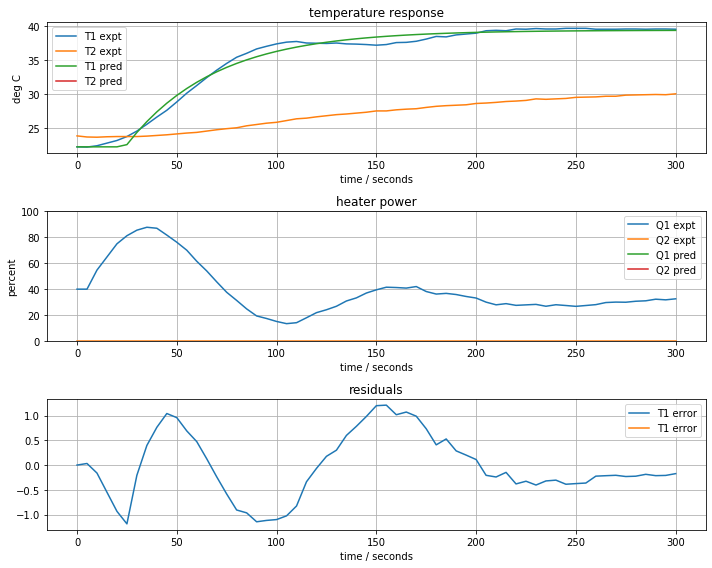

In [155]:
def model_first_order_delay1(param, plot=False):
    K, tau, t_delay = param
    pred = pd.DataFrame(columns=["T1", "T2", "Q1", "Q2"], index=t_expt)
    pred["T1"] = [T_amb1 + K*U1bar*(1 - np.exp(-(t-t_delay)/tau)) if t > t_delay else T_amb1 for t in t_expt]
    if plot:
        plot_data(data2, pred)
    return pred["T1"] - data2["T1"]

data2 = pd.read_csv('sim_test_single controller.csv')
data2.index = data2['Time']

T_amb1 = 22.284
U1bar = data2["Q1"].mean()
t_expt = data2.index

# initial guesses for parameters
K1 = 1
tau1 = 200
t_delay1 = 40

model_first_order_delay1([K1, tau1, t_delay1])

results1 = least_squares(model_first_order_delay1,  [K1, tau1, t_delay1])
K1, tau1, t_delay1 = results1.x
print(f"K = {K1},  tau = {tau1}, time delay = {t_delay1}")
model_first_order_delay1([K1, tau1, t_delay1],True)

### Controller Statistics Summary:
Dead time estimate: 24.15 seconds

Time constant estimate: 44.50 seconds

Gain: 1 (dimensionless); note this is not reflected in the regression above, which is optimized to return an accurate measurement of tau and the delay.  Because the Kp and Ki values for this controller are taken from lab 3, this is not a confounding issue.

In [156]:
def model_first_order_delay2(param, plot=False):
    K, tau, t_delay = param    
    pred = pd.DataFrame(columns=["T1", "T2", "Q1", "Q2"], index=t_expt)
    # I include the set point and a dimensionless K here to acknowlege that the outer controller does not cause
    # perturbations in the heater power or strength at all, but instead manipulates the Set Point for T1
    pred["T2"] = [T_amb2 + K*SP1bar*(1 - np.exp(-(t-t_delay)/tau)) if t > t_delay else T_amb2 for t in t_expt]
    if plot:
        plot_data(data2, pred)
    return pred["T2"] - data2["T2"]

data2 = pd.read_csv('sim_test_single controller.csv')
data2.index = data2['Time']

T_amb2 = 23.896
SP1bar = 40 # I held the set point constant for the above experiment, so the average is merely the value itself
t_expt = data2.index

# initial guesses for parameters
K2 = 0.15
tau2 = 200
t_delay2 = 40

model_first_order_delay2([K2, tau2, t_delay2])

results2 = least_squares(model_first_order_delay2,  [K, tau2, t_delay2])
K2, tau2, t_delay2 = results2.x
print(f"K = {K2},  tau = {tau2}, time delay = {t_delay2}")

K = 0.20555300976942817,  tau = 176.7708278648307, time delay = 48.16309812354842


In [161]:
# utilize above values to find Ki and Kp for outer controller; I am taking the above values to be the inputs for 
# tuning rules and utilizing the Astrom and Murray rules for consistency with Question 1
Kp_out = (0.15*t_delay2+0.35*tau2)/(K2*t_delay2)
Ki_out = (0.46*t_delay2+0.02*tau2)/(K2*t_delay2**2)

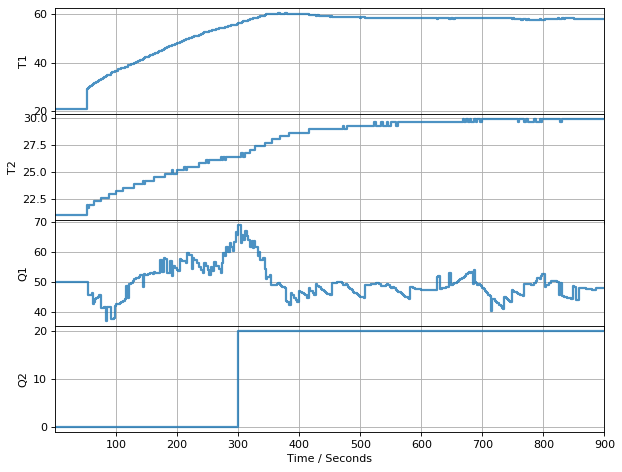

TCLab Model disconnected successfully.


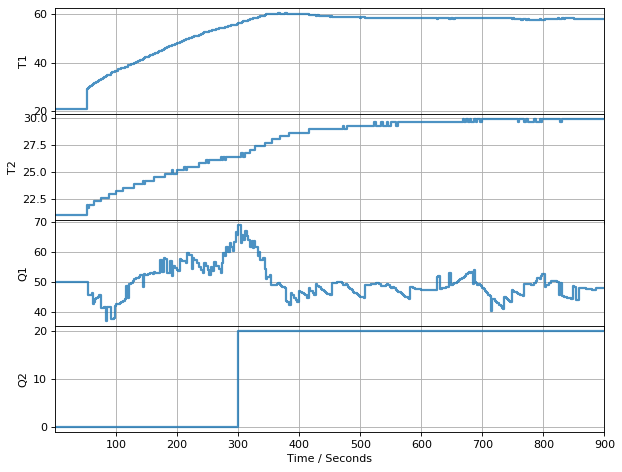

In [169]:
# excecute cascade control
Kp_in = 13
Ki_in = 0.18
t_final = 900
t_step = 2
sim_double_loop(PI_bumpless(Kp_out,Ki_out),PI_bumpless(Kp_in,Ki_in),t_final,t_step)

Below is the final run for the cascade controller.  The set point was acquired (thank God!)

In [193]:
def run_double_loop(controller_outer, controller_inner, t_final, t_step,
               SP2=lambda t: 30 if t >=0 else 0,
               DV=lambda t: 20 if t >= 300 else 0,
               MVU=lambda t: 0 if t <= 0 else None,
               MVT=lambda t: 40 if t <= 0 else None):
    with TCLab() as lab:

        # set up historian and plotter
        h = Historian(lab.sources)
        p = Plotter(h, t_final)
        # powers are specified at top of this notebook
        lab.P1 = P1
        lab.P2 = P2
        # initialize manipulated variable
        lab.Q1(next(controller_inner))
        SP1 = next(controller_outer)

        # event loop
        for t in clock(t_final, t_step):
            T2 = lab.T2
            T1 = lab.T1
            U1 = lab.Q1()
            # outer loop occurs first; returns value for SP1
            if MVT(t) is None:           
                SP1 = controller_outer.send((t_step, SP2(t), T2, SP1))
            else:
                SP1 = MVT(t)                            # manual override for heater unit 1 temperature set point
            # inner loop occurs second, and responds to outer loop direction by specifying the heater power
            if MVU(t) is None:
                U1 = controller_inner.send((t_step, SP1, T1, U1))
            else:
                U1 = MVU(t)                             # manual override for heater unit 1 power
            lab.Q1(U1)
            lab.Q2(DV(t))
            p.update(t)
            
        h.to_csv('run_double_loop.csv')

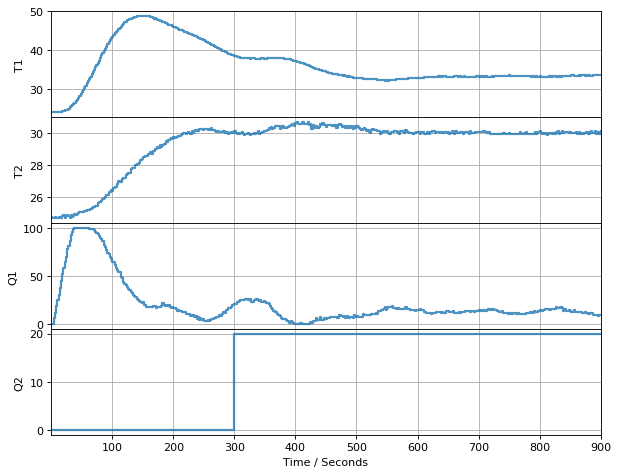

TCLab disconnected successfully.


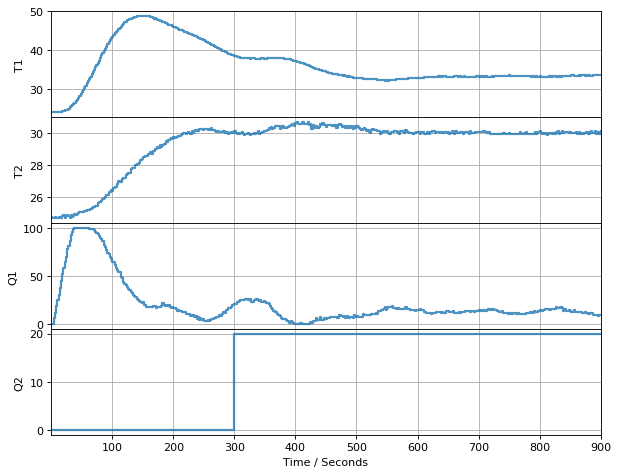

In [194]:
run_double_loop(PI_bumpless(Kp_out,Ki_out),PI_bumpless(Kp_in,Ki_in),t_final,t_step)

### Review
Overall, the cascade controller did a much better job regulating the temperature, especially through the distubrance.  The T2 set point was acquired much earlier in the run, and the final equilibrium temperature was achieved much earlier.  In my run with only one controller, I noticed that the system had a hard time reconciling the disturbance and relaxing down so that the temperature could relax to the set point.  In fact, 15 minutes was not enough to reach the set point-based on the trend at the end of that run, either more time or adjustment to Kp and Ki are required, since the equilibrium seemed to fall slightly above the set point once the disturbance was introduced.  Because the value of T1 was so regulated in the cascade controller, this was not and issue the second time.  Overall, it seems that the cascade controller is not only more efficient in reaching a set point, but is also better suited to deal with "unexpected" disturbances in the physical machinery or code.